<a href="https://colab.research.google.com/github/JoanneBurke/NLP-Projects/blob/master/BiLSTM_74__WRI_text.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [0]:
import pandas as pd
import nltk
nltk.download('stopwords')
from nltk.corpus import stopwords

import gensim
from gensim.utils import simple_preprocess
from tqdm import tqdm as tqdm

from collections import Counter
import numpy as np

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [0]:
pwd

'/content'

In [0]:
import os

% cd drive/My Drive/Colab Notebooks/Omdena_WRI_JB/

% pwd
% ls

[Errno 2] No such file or directory: 'drive/My Drive/Colab Notebooks/Omdena_WRI_JB/'
/content/drive/My Drive/Colab Notebooks/Omdena_WRI_JB
'Copy of Attempt Bert.ipynb'          NER_ents.csv
 environmental-conflict-tracker/      PolicyMatch.csv
'Gabriella -  LSTM_WRI.ipynb'         PolicyMatch.gsheet
' Gabriella -  LSTM_WRI_text.ipynb'   Unlabelled1023.csv
 gold_standard.csv                   'wri_102919 (1).csv'
 manually_annotated.csv               wri.csv
'NER and Matcher attempts.ipynb'     'WRI titles NN - 1st pass.ipynb'


In [0]:
total= pd.read_csv('/content/drive/My Drive/Colab Notebooks/Omdena_WRI_JB/wri_102919 (1).csv', encoding='utf-8')

In [0]:
total['labels'].value_counts()

negative    1344
positive     459
Name: labels, dtype: int64

In [0]:
total['class_binary']=total['labels'].map({'negative':0,'positive':1})

In [0]:
total['text']= total['text'].str.replace(r'\d+','')
total['text ']= total['text'].str.replace(r'\s+',' ')
total['text']= total['text'].str.lower().str.strip()

In [0]:
total= total[~total.text.isna()]

In [0]:
X= total.text.values
y= total['class_binary'].values

In [0]:
def sent_to_words(X):
    '''Tokenizar las normas y eliminar puntuacion restante (acentos)'''
    for linea in X:
        yield(gensim.utils.simple_preprocess(str(linea), deacc=True))  # deacc=True removes punctuations

X_token = list(sent_to_words(X))

In [0]:
stop_words= stopwords.words('english')

In [0]:
def no_stopwords(X):
    return [[word for word in line if word not in stop_words] for line in tqdm(X)]

In [0]:
X_no_stopwords= no_stopwords(X_token)

100%|██████████| 1803/1803 [00:01<00:00, 1463.27it/s]


In [0]:
vocab= Counter()
for line in X_no_stopwords:
    for word in line:
        vocab[word]+=1

vocab= sorted(vocab, key= vocab.get, reverse=True)
word_to_id= {word:i for i,word in enumerate(vocab,1)}

In [0]:
encoded_x= [[word_to_id[word] for word in line] for line in X_no_stopwords]

In [0]:
largo=[]
for i,line in enumerate(X_no_stopwords):
  largo.append(len(line))

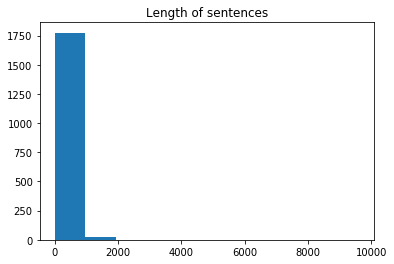

In [0]:
import matplotlib.pyplot as plt
plt.hist(largo)
plt.title('Length of sentences')
plt.show()

In [0]:
MAX_LENGTH = 300
EPOCHS = 15
S_DROPOUT = .05
DROPOUT = .05
R_DROPOUT = .05



In [0]:
"""def cut_pad(text, length_seq):
    seq=[]
    for line in text:
        if len(line)>=length_seq:
            seq.append(line[:length_seq])
        else:
            padding=[0]*(length_seq-len(line))
            seq.append(padding+line)
    return seq
  
padded_X = cut_pad(encoded_x,12)
padded_X= np.array(padded_X)"""

from keras.preprocessing.sequence import pad_sequences

padded_X= pad_sequences(encoded_x,maxlen=MAX_LENGTH)
padded_X.shape

(1803, 300)

In [0]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(padded_X, y,
                                                    stratify=y, 
                                                    test_size=0.2)

In [0]:
from keras.datasets import imdb
from keras.models import Sequential
from keras.layers import Dense, LSTM, SpatialDropout1D, Bidirectional
from keras.layers.embeddings import Embedding
from keras.preprocessing import sequence

In [0]:
np.random.seed(7)

embedding_vector_length = 32

model = Sequential()
model.add(Embedding(len(word_to_id)+1, embedding_vector_length, input_length=MAX_LENGTH))
model.add(SpatialDropout1D(S_DROPOUT))
model.add(Bidirectional(LSTM(60,dropout = DROPOUT, recurrent_dropout = R_DROPOUT)))
model.add(Dense(1, activation='sigmoid'))
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
print(model.summary())
model.fit(X_train, y_train, epochs=EPOCHS, batch_size=128)
# Final evaluation of the model
scores = model.evaluate(X_test, y_test, verbose=0)
print("Accuracy: %.2f%%" % (scores[1]*100))

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_3 (Embedding)      (None, 300, 32)           1120192   
_________________________________________________________________
spatial_dropout1d_3 (Spatial (None, 300, 32)           0         
_________________________________________________________________
bidirectional_3 (Bidirection (None, 120)               44640     
_________________________________________________________________
dense_3 (Dense)              (None, 1)                 121       
Total params: 1,164,953
Trainable params: 1,164,953
Non-trainable params: 0
_________________________________________________________________
None
Epoch 1/15
1442/1442 [==============================] - 15s 10ms/step - loss: 0.6595 - acc: 0.7393
Epoch 2/15
1442/1442 [==============================] - 12s 8ms/step - loss: 0.5641 - acc: 0.7455
Epoch 3/15
1442/1442 [==================

In [0]:
prediction = np.array([1 if pred>=0.5 else 0 for pred in model.predict(X_test)])

true_positive= np.sum(prediction*y_test)
false_positive= np.sum((y_test[np.where(prediction==1)]*prediction[np.where(prediction==1)])==0)
false_negative=np.sum((y_test[np.where(prediction==0)]+prediction[np.where(prediction==0)])==1)
true_negative = len(prediction) - true_positive - false_negative - false_positive

precision= true_positive/(true_positive+false_positive)
recall= true_positive/(true_positive+false_negative)

f1= 2* precision* recall/(precision+recall)

print('Precision: ', precision)
print('Recall: ', recall)
print('F1: ', f1)
print('-'*65)
print('True Positives: ', true_positive)
print('True Negatives: ', true_negative)
print('False Positives: ', false_positive)
print('False Negatives: ', false_negative)


Precision:  0.8076923076923077
Recall:  0.6847826086956522
F1:  0.7411764705882354
-----------------------------------------------------------------
True Positives:  63
True Negatives:  254
False Positives:  15
False Negatives:  29


In [0]:
from tensorflow.keras.models import save_model
model.save_weights('text_bilstm_weights.hdf5')
model.save('text_bilstm_model.hdf5')

In [0]:
dir(model)

['__call__',
 '__class__',
 '__delattr__',
 '__dict__',
 '__dir__',
 '__doc__',
 '__eq__',
 '__format__',
 '__ge__',
 '__getattribute__',
 '__getstate__',
 '__gt__',
 '__hash__',
 '__init__',
 '__init_subclass__',
 '__le__',
 '__lt__',
 '__module__',
 '__ne__',
 '__new__',
 '__reduce__',
 '__reduce_ex__',
 '__repr__',
 '__setattr__',
 '__setstate__',
 '__sizeof__',
 '__str__',
 '__subclasshook__',
 '__weakref__',
 '_add_inbound_node',
 '_base_init',
 '_build_input_shape',
 '_built',
 '_check_trainable_weights_consistency',
 '_collected_trainable_weights',
 '_compute_previous_mask',
 '_expects_training_arg',
 '_feed_input_names',
 '_feed_input_shapes',
 '_feed_inputs',
 '_feed_loss_fns',
 '_feed_output_names',
 '_feed_output_shapes',
 '_feed_outputs',
 '_feed_sample_weight_modes',
 '_feed_sample_weights',
 '_feed_targets',
 '_function_kwargs',
 '_get_callback_model',
 '_get_node_attribute_at_index',
 '_inbound_nodes',
 '_init_graph_network',
 '_init_subclassed_network',
 '_initial_weigh